<a href="https://colab.research.google.com/github/lisphilar/covid19-sir/blob/master/example/03_ode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIR-derived ODE models
SIR-derived ODE (ordinary differential equation) models are used in epidemiology. They are also named as compartment models and useful to understand the dynamics of outbreak of infectious diseases, including COVID-19.

Mathematical model enables us to describe complicated systems with some parameters simply. So, we can study how to predict and end the outbreak in epidemiology.

In [84]:
from copy import deepcopy
from pprint import pprint
try:
    import covsirphy as cs
except ImportError:
    !pip install --upgrade "git+https://github.com/lisphilar/covid19-sir.git#egg=covsirphy" -qqq
    import covsirphy as cs
import numpy as np
cs.__version__

'2.24.0-xi'

## 1. SIR model
SIR model is the simplet mathematical model with ODEs. Population is assigned to compartments named as follows.

Let’s start with the simplest SIR model proposed by [Kermack, W. O., & McKendrick, A. G. (1927)](https://royalsocietypublishing.org/doi/10.1098/rspa.1927.0118). Population is assigned to some compartments. "Susceptible people" may meet "Infected" patients and may be confirmed as "Infected". "Infected" patients will move to "Removed (Recovered or Fatal)" compartment later.

### 1-1. Definition

\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
\end{align*}

Variables:  

* $\mathrm{S}$: Susceptible (= Population - Confirmed)  
* $\mathrm{I}$: Infected (=Confirmed - Recovered - Fatal)  
* $\mathrm{R}$: Recovered or Fatal (= Recovered + Fatal)  

Parameters:  

* $\beta$: Effective contact rate $\mathrm{[1/min]}$  
* $\gamma$: Recovery (+ Mortality) rate $\mathrm{[1/min]}$  

Note:  
Though $R$ in SIR model is "Recovered and have immunity", we defines $R$ as "Recovered or fatal". This is because mortality rate cannot be ignored in our COVID-19 outbreak.

### 1-2. Non-dimensional SIR model
To simplify the model, we will remove the units of the variables from the ODE model.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - \sigma y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).

Note regarding the roles of ODE parameter values:  
When $\rho$ is large, $\beta$ is large. When $\beta$ (effective contact rate [1/min]) is large, S -> I is faster because dI/dT = $\beta$ * [S] [I].

### 1-3. Create sample data
We use `SIRModel` class, a child class of `ODEModel`. They have class method `.from_sample(date_range=None, tau=1440)` (as default) and this method creates an instance with preset parameter values and initial values of variables.

In [85]:
sir = cs.SIRModel.from_sample()
repr(sir)

"SIRModel(date_range=('30Jul2022', '26Jan2023'), tau=1440, initial_dict={'Susceptible': 999000, 'Infected': 1000, 'Fatal or Recovered': 0}, param_dict={'rho': 0.2, 'sigma': 0.075})"

We can specify the start/end date of dynamics and tau value as follows. Note that tau value [min] should be a divisor of 1440 to simplify operations.

In [86]:
cs.SIRModel.from_sample(date_range=("01Jan2022", "31Dec2022"), tau=720)

SIRModel(date_range=('01Jan2022', '31Dec2022'), tau=720, initial_dict={'Susceptible': 999000, 'Infected': 1000, 'Fatal or Recovered': 0}, param_dict={'rho': 0.2, 'sigma': 0.075})

When we need to change the values of arguments, create an instance directly with the class.

In [87]:
cs.SIRModel(
    date_range=('01Jan2022', '31Dec2022'),
    tau=720,
    initial_dict={'Susceptible': 995_000, 'Infected': 4_000, 'Fatal or Recovered': 1_000},
    param_dict={'rho': 0.4, 'sigma': 0.075}
)

SIRModel(date_range=('01Jan2022', '31Dec2022'), tau=720, initial_dict={'Susceptible': 995000, 'Infected': 4000, 'Fatal or Recovered': 1000}, param_dict={'rho': 0.4, 'sigma': 0.075})

We can also confirm the settings and definitions of the instance with instance method `ODEModel().settings()` and class method `ODEModel.definition()`.

In [88]:
pprint(sir.settings())

{'date_range': ('30Jul2022', '26Jan2023'),
 'initial_dict': {'Fatal or Recovered': 0,
                  'Infected': 1000,
                  'Susceptible': 999000},
 'param_dict': {'rho': 0.2, 'sigma': 0.075},
 'tau': 1440}


In [89]:
# pprint(cs.SIRModel.definitions())
pprint(sir.definitions())

{'dimensional_parameters': ['1/beta [day]', '1/gamma [day]'],
 'name': 'SIR Model',
 'parameters': ['rho', 'sigma'],
 'variables': ['Susceptible', 'Infected', 'Fatal or Recovered']}


We can calculate dimentional parameter values with `ODEModel().dimensional_parameters()`.

In [90]:
sir.dimensional_parameters()

{'1/beta [day]': 5, '1/gamma [day]': 13}

### 1-4. Solve ODEs
We can solve the ODEs with `ODEModel().solve()`.

In [91]:
sir_df = sir.solve()
sir_df.tail()

,Susceptible,Infected,Fatal or Recovered
Date,,,
2023-01-22,88354,750,910895
2023-01-23,88342,708,910950
2023-01-24,88329,669,911002
2023-01-25,88318,632,911050
2023-01-26,88307,596,911096


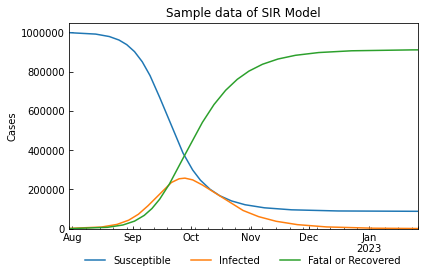

In [92]:
cs.line_plot(sir_df, title=f"Sample data of {sir}", y_integer=True)

### 1-5. Reproduction number
Reproduction number of SIR model is defined as follows.

\begin{align*}
R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}
\end{align*}

$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([external link: Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  

We can calculate reproduction number using `ODEModel().r0()` method.

In [93]:
sir.r0()

2.67

When $x=\frac{1}{R_0}$, $\frac{\mathrm{d}y}{\mathrm{d}t}=0$ (the number of infected cases does not change)  
because $\frac{\mathrm{d}y}{\mathrm{d}t}=\rho x y - \sigma y=\rho \times (\rho \sigma^{-1})^{-1} \times y - \sigma y=0$.

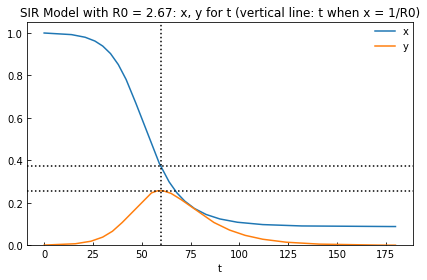

In [94]:
model = deepcopy(sir)
df = sir_df.copy()
# Calculate R0
r0 = model.r0()
# Prepare non-dimentional values
tau = model.settings()["tau"]
df.index = ((df.index - df.index.min()) / np.timedelta64(1440, "m")).astype(np.int64)
df.index.name = "t"
population = sum(model.settings()["initial_dict"].values())
df["x"] = df["Susceptible"] / population
df["y"] = df["Infected"] / population
# t for x = 1/R0
t0 = np.argmin(np.abs(df["x"] - 1/r0))
# y when x = 1/R0
y0 = df.loc[t0, "y"]
# Show x, y for t
cs.line_plot(
    df[["x", "y"]],
    title=f"{model} with R0 = {r0}: x, y for t (vertical line: t when x = 1/R0)", xlabel="t", math_scale=False, ylabel=None,
    h=[1/r0, y0], v=t0,
    bbox_to_anchor=None, bbox_loc="upper right", ncol=1,
)

## 2. SIR-D model
Because we are measuring the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model. We call this model as SIR-D model.

### 2-1. Definition

\begin{align*}
\mathrm{S} \overset{\beta  I}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
& \mathrm{I} \overset{\alpha}{\longrightarrow} \mathrm{D}  \\
\end{align*}

Variables:  

* $\mathrm{S}$: Susceptible (= Population - Confirmed)  
* $\mathrm{I}$: Infected (=Confirmed - Recovered - Fatal)  
* $\mathrm{R}$: Recovered  
* $\mathrm{D}$: Fatal  

Parameters:  

* $\alpha$: Mortality rate $\mathrm{[1/min]}$  
* $\beta$: Effective contact rate $\mathrm{[1/min]}$  
* $\gamma$: Recovery rate $\mathrm{[1/min]}$  

### 2-2. Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, w)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y  \\
\end{align*}

### 2-3. Create sample data
We use `SIRDModel` class, a child class of `ODEModel`. They have class method `.from_sample(date_range=None, tau=1440)` (as default).

In [95]:
sird = cs.SIRDModel.from_sample()
repr(sird)

"SIRDModel(date_range=('30Jul2022', '26Jan2023'), tau=1440, initial_dict={'Susceptible': 999000, 'Infected': 1000, 'Recovered': 0, 'Fatal': 0}, param_dict={'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075})"

### 2-4. Solve ODEs
We can solve the ODEs with `ODEModel().solve()`.

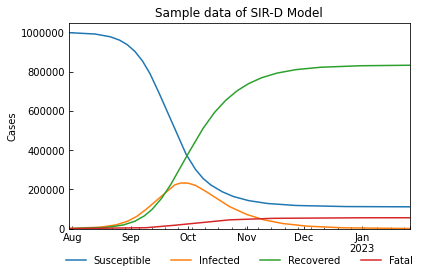

In [96]:
sird_df = sird.solve()
cs.line_plot(sird_df, title=f"Sample data of {sird}", y_integer=True)

### 2-5. Reproduction number
Reproduction number of SIR-D model is defined as follows.

\begin{align*}
R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}
\end{align*}

In [97]:
sird.r0()

2.5

## 3. SIR-F model
In the initial phase of COVID-19 outbreak, many cases were confirmed after they died. To consider this issue, "S + I $\to$ Fatal + I" should be added. We call the next model as SIR-F model. This is an original model of CovsirPhy. When $\alpha_{1}=0$, no difference with the SIR-D model.

SIR-F model was developed with [Kaggle: COVID-19 data with SIR model](https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model#SIR-to-SIR-F).

### 3-1. Definition

\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

Variables:  

* $\mathrm{S}$: Susceptible (= Population - Confirmed)  
* $\mathrm{S}^\ast$: Confirmed and un-categorized  
* $\mathrm{I}$: Confirmed and categorized as Infected  
* $\mathrm{R}$: Confirmed and categorized as Recovered  
* $\mathrm{F}$: Confirmed and categorized as Fatal  

Parameters:  

* $\alpha_1$: Direct fatality probability of $\mathrm{S}^\ast$ (non-dimensional) 
* $\alpha_2$: Mortality rate of Infected cases $\mathrm{[1/min]}$  
* $\beta$: Effective contact rate $\mathrm{[1/min]}$  
* $\gamma$: Recovery rate $\mathrm{[1/min]}$  


Notes on $\mathrm{S}^\ast$ variable:  
$\mathrm{S}^\ast$ describes the cases who are actually carriers of the disease without anyone (including themselves) knowing about it, who either die and they are confirmed positive after death, while some others are moved to infected after being confirmed.

In JHU-style dataset, we know the number of cases who were confirmed with COVID-19, but we do not know the number of died cases who died without COVID-19.
Essentially $\mathrm{S}^\ast$ serves as an auxiliary compartment in SIR-F model to separate the two death situations and insert a probability factor of {$\alpha_1$, $1 - \alpha_1$}.  

Note regarding the roles of ODE parameter values:  
When $\rho$ is large, $\beta$ is large. When $\beta$ (effective contact rate [1/min]) is large, S -> S* -> I is faster because dS*/dT = $\beta$ * [S] [I].  
When $\theta$ is large, $\alpha_1$ is large. When $\alpha_1$ (direct fatality probability) is large, S -> S* -> F is faster because dF/dT = $\alpha_1$ * [S*] + $\alpha_2$ * [I].

Notes on the difference of SIR-D and SIR-F model:  
$\alpha_1$ is small at this time because performance of PCR tests was improved, but we can use SIR-F model rather than SIR-D model as an enhanced model even now because $\alpha_1$ can be 0 in the ODE model.

### 3-2. Non-dimensional SIR-F model
Set $(S, I, R, F) = N \times (x, y, z, w)$ and $(T, \alpha_1, \alpha_2, \beta, \gamma) = (\tau t, \theta, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y  \\
\end{align*}

### 3-3. Create sample data
We use `SIRFModel` class, a child class of `ODEModel`. They have class method `.from_sample(date_range=None, tau=1440)` (as default).

In [98]:
sirf = cs.SIRFModel.from_sample()
repr(sirf)

"SIRFModel(date_range=('30Jul2022', '26Jan2023'), tau=1440, initial_dict={'Susceptible': 999000, 'Infected': 1000, 'Recovered': 0, 'Fatal': 0}, param_dict={'theta': 0.002, 'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075})"

### 3-4. Solve ODEs
We can solve the ODEs with `ODEModel().solve()`.

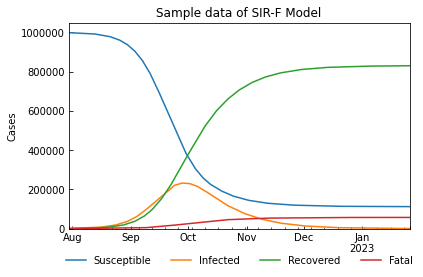

In [99]:
sirf_df = sirf.solve()
cs.line_plot(sirf_df, title=f"Sample data of {sirf}", y_integer=True)

### 3-5. Reproduction number
Reproduction number of SIR-F model is defined as follows.

\begin{align*}
R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1} = \beta (1 - \alpha_1) (\gamma + \alpha_2)^{-1}
\end{align*}

In [100]:
sirf.r0()

2.5

## 4. SIR-F with exposed/waiting cases
The next model is SEWIR-F model.  
The number of exposed cases in latent period (E) and waiting cases for confirmation (W) are un-measurable variables, but key variables as well as S, I, R, F. If E and W are large, outbreak will occur in the near future. Let's replace S$\overset{\beta I}{\longrightarrow}$S$^\ast$ as follows because W also has infectivity.

Note:  
**We cannot use SEWIR-F model for parameter estimation because we do not have records of Exposed and Waiting. Please use SIR-F model.**

### 4-1. Definition

\begin{align*}
\mathrm{S} \overset{\beta_1 (W+I)}{\longrightarrow} \mathrm{E} \overset{\beta_2}{\longrightarrow} \mathrm{W} \overset{\beta_3}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

Variables:  

* $\mathrm{S}$: Susceptible  
* $\mathrm{E}$: <u>Exposed and in latent period (without infectivity)</u>  
* $\mathrm{W}$: <u>Waiting for confirmation diagnosis (with infectivity)</u>  
* $\mathrm{S}^\ast$: Confirmed and un-categorized  
* $\mathrm{I}$: Confirmed and categorized as Infected  
* $\mathrm{R}$: Confirmed and categorized as Recovered  
* $\mathrm{F}$: Confirmed and categorized as Fatal  

Parameters:  

* $\alpha_1$: Direct fatality probability of $\mathrm{S}^\ast$ (non-dimensional) 
* $\alpha_2$: Mortality rate of Infected cases $\mathrm{[1/min]}$  
* $\beta_1$: <u>Exposure rate (the number of encounter with the virus in a minute)</u> $\mathrm{[1/min]}$  
* $\beta_2$: <u>Inverse of latent period</u> $\mathrm{[1/min]}$  
* $\beta_3$: <u>Inverse of waiting time for confirmation</u> $\mathrm{[1/min]}$  
* $\gamma$: Recovery rate $\mathrm{[1/min]}$ 

### 4-2. Non-dimensional SEWIR-F model
Set $(S, E, W, I, R, F) = N \times (x_1, x_2, x_3, y, z, w)$, $(T, \alpha_1) = (\tau t, \theta)$ and $(\alpha_2, \beta_i, \gamma) = \tau^{-1} \times (\kappa, \rho_i, \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x_1}{\mathrm{d}t}= - \rho_1 x_1 (x_3 + y)  \\
& \frac{\mathrm{d}x_2}{\mathrm{d}t}= \rho_1 x_1 (x_3 + y) - \rho_2 x_2  \\
& \frac{\mathrm{d}x_3}{\mathrm{d}t}= \rho_2 x_2 - \rho_3 x_3  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= (1-\theta) \rho_3 x_3 - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \theta \rho_3 x_3 + \kappa y  \\
\end{align*}

### 4-3. Create sample data
We use `SEWIRFModel` class, a child class of `ODEModel`. They have class method `.from_sample(date_range=None, tau=1440)` (as default).

In [101]:
sewirf = cs.SEWIRFModel.from_sample()
repr(sewirf)

"SEWIRFModel(date_range=('30Jul2022', '26Jan2023'), tau=1440, initial_dict={'Susceptible': 994000, 'Exposed': 3000, 'Waiting': 2000, 'Infected': 1000, 'Recovered': 0, 'Fatal': 0}, param_dict={'theta': 0.002, 'kappa': 0.005, 'rho1': 0.2, 'rho2': 0.167, 'rho3': 0.167, 'sigma': 0.075})"

### 3-4. Solve ODEs
We can solve the ODEs with `ODEModel().solve()`.

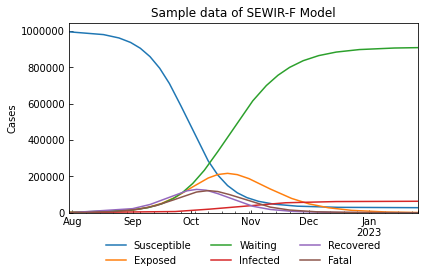

In [102]:
sewirf_df = sewirf.solve()
cs.line_plot(sewirf_df, title=f"Sample data of {sewirf}", y_integer=True, bbox_to_anchor=(0.5, -0.3), ncol=3)

### 4-5. Reproduction number
Reproduction number of SEWIR-F model is defined as follows.

\begin{align*}
R_0 = \rho_1 /\rho_2 * \rho_3 (1-\theta) (\sigma + \kappa)^{-1}
\end{align*}

In [103]:
sewirf.r0()

2.49

## 5. SIR-F with vaccination
Vaccination is a key factor to prevent outbreak as you know.

In the previous version, we defined SIR-FV model with $\omega$ (vaccination rate) and
$$
\frac{\mathrm{d}S}{\mathrm{d}T}= - \beta S I - \omega N  \\
$$

However, **SIR-FV model was removed because vaccinated persons may move to the other compartments, including "Susceptible". Please use SIR-F model for simulation and parameter estimation with adjusted parameter values, considering the impact of vaccinations on infectivity, its effectivity and safety.**

## 6. SIR-F with re-infection
Re-infection (Recovered -> Susceptible) is sometimes reported and we can consider SIR-S (SIR-FS) model. However, this is not implemented at this time because we do not have data regarding re-infection. SIR-F model could be the final model in our data-driven approach at this time.  

Re-infection changes the parameter values of SIR-F model. There are two patterns.

1. If re-infected case are counted as new confirmed cases and removed from "Recovered" compartment, $\sigma$ will be decreased.
2. If re-infected cases are counted as new confirmed cases and **NOT** removed from "Recovered" compartment, $\rho$ will be increased because "Susceptible" will be decreased.

Thank you!